# AutoTrader Car Price Regression — Exploratory Notebook

This notebook is rough work: short notes, checks, and iteration. The aim is to show modelling judgement and diagnostics rather than produce a polished report.

## 1. Setup and Environment

Notes:
- I set seeds so any sampling/splitting is reproducible.
- Assumed: Python 3.10+ with pandas/numpy/matplotlib/scikit-learn.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
    from IPython.display import display
except Exception:
    def display(x):
        print(x)

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import (
    r2_score, mean_absolute_error, mean_squared_error, make_scorer
)

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
rng = np.random.default_rng(RANDOM_STATE)

# Metric contract (used everywhere)
def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

MAE_SCORER = make_scorer(mean_absolute_error, greater_is_better=False)
RMSE_SCORER = make_scorer(rmse, greater_is_better=False)
R2_SCORER = make_scorer(r2_score)

import sklearn
print("Versions:")
print(f"  sklearn: {sklearn.__version__}")
print(f"  pandas:  {pd.__version__}")
print(f"  numpy:   {np.__version__}")

Versions:
  sklearn: 1.6.1
  pandas:  2.2.2
  numpy:   2.0.2


## 2. Data Loading and Initial Sanity Checks

I’m loading via Google Drive in Colab. If you are not in Colab, replace the path and remove the mount cell.

In [3]:
from pathlib import Path
import pandas as pd

# Local-first for marking
LOCAL_PATH = Path("advertsAuto.csv")

# Drive fallback (only if running in Colab and mounted)
DRIVE_PATH = Path("/content/drive/MyDrive/MSC Artificial intelligence 2026/MSC_AI_Q1/MLC/MLC2.0/advertsAuto.csv")

# Try mounting Drive only if Colab exists
try:
    from google.colab import drive  # type: ignore
    drive.mount("/content/drive")
    print("Drive mounted.")
except Exception:
    pass

if LOCAL_PATH.exists():
    DATA_PATH = LOCAL_PATH
elif DRIVE_PATH.exists():
    DATA_PATH = DRIVE_PATH
else:
    raise FileNotFoundError(
        "Dataset not found.\n"
        f"Tried local: {LOCAL_PATH.resolve()}\n"
        f"Tried drive: {DRIVE_PATH}"
    )

print(f"Loading dataset from: {DATA_PATH}")
df = pd.read_csv(DATA_PATH, low_memory=False)
print("shape:", df.shape)
display(df.head())

Mounted at /content/drive
Drive mounted.
Loading dataset from: /content/drive/MyDrive/MSC Artificial intelligence 2026/MSC_AI_Q1/MLC/MLC2.0/advertsAuto.csv
shape: (402005, 12)


,public_reference,mileage,reg_code,standard_colour,standard_make,standard_model,vehicle_condition,year_of_registration,price,body_type,crossover_car_and_van,fuel_type
0,202006039777689,0.0,NaN,Grey,Volvo,XC90,NEW,NaN,73970,SUV,False,Petrol Plug-in Hybrid
1,202007020778260,108230.0,61,Blue,Jaguar,XF,USED,2011.0,7000,Saloon,False,Diesel
2,202007020778474,7800.0,17,Grey,SKODA,Yeti,USED,2017.0,14000,SUV,False,Petrol
3,202007080986776,45000.0,16,Brown,Vauxhall,Mokka,USED,2016.0,7995,Hatchback,False,Diesel
4,202007161321269,64000.0,64,Grey,Land Rover,Range Rover Sport,USED,2015.0,26995,SUV,False,Diesel


In [4]:
# Cell 3 — Data audit (dtypes, missingness, target sanity, cardinality)
TARGET = "price"
assert TARGET in df.columns, f"{TARGET} not found"

df.info()

missing = (df.isna().mean().sort_values(ascending=False) * 100).to_frame("missing_%")
display(missing.head(15))

print("\nTarget (price) quick stats:")
display(df[TARGET].describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99]))

print("\nUnique counts (cardinality):")
display(df.nunique().sort_values(ascending=False).to_frame("n_unique").head(15))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402005 entries, 0 to 402004
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   public_reference       402005 non-null  int64  
 1   mileage                401878 non-null  float64
 2   reg_code               370148 non-null  object 
 3   standard_colour        396627 non-null  object 
 4   standard_make          402005 non-null  object 
 5   standard_model         402005 non-null  object 
 6   vehicle_condition      402005 non-null  object 
 7   year_of_registration   368694 non-null  float64
 8   price                  402005 non-null  int64  
 9   body_type              401168 non-null  object 
 10  crossover_car_and_van  402005 non-null  bool   
 11  fuel_type              401404 non-null  object 
dtypes: bool(1), float64(2), int64(2), object(7)
memory usage: 34.1+ MB


,missing_%
year_of_registration,8.286215
reg_code,7.924528
standard_colour,1.337794
body_type,0.208206
fuel_type,0.149501
mileage,0.031592
public_reference,0.000000
standard_make,0.000000
vehicle_condition,0.000000
standard_model,0.000000



Target (price) quick stats:


,price
count,4.020050e+05
mean,1.734197e+04
std,4.643746e+04
min,1.200000e+02
1%,1.150000e+03
5%,2.495000e+03
50%,1.260000e+04
95%,4.384240e+04
99%,8.889952e+04
max,9.999999e+06



Unique counts (cardinality):


,n_unique
public_reference,402005
mileage,80634
price,30578
standard_model,1168
standard_make,110
year_of_registration,84
reg_code,72
standard_colour,22
body_type,16
fuel_type,9


Target sanity: price is typically heavily right-skewed in car adverts, and a few extreme listings can dominate squared-error models.

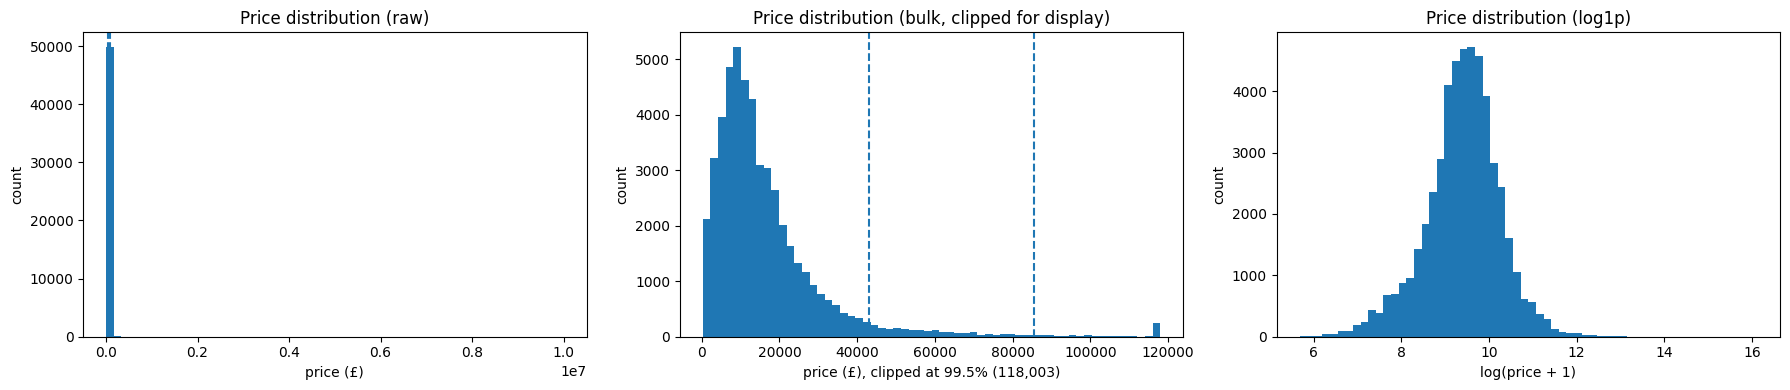

Sample size: 50,000
Visual clip cap (99.5%): £118,003
p95: £43,000 | p99: £85,502
Note: clipping here is for visualisation only; modelling thresholds are fit on training only.


In [5]:
# Target distribution (raw + clipped + log) — screenshot for report
sample_n = min(50_000, len(df))
sample = df[[TARGET]].dropna().sample(n=sample_n, random_state=RANDOM_STATE)

p95 = sample[TARGET].quantile(0.95)
p99 = sample[TARGET].quantile(0.99)

clip_cap = sample[TARGET].quantile(0.995)
sample_clip = sample[TARGET].clip(upper=clip_cap)

fig, axes = plt.subplots(1, 3, figsize=(18, 4))

axes[0].hist(sample[TARGET], bins=60)
axes[0].axvline(p95, linestyle="--")
axes[0].axvline(p99, linestyle="--")
axes[0].set_xlabel("price (£)")
axes[0].set_ylabel("count")
axes[0].set_title("Price distribution (raw)")

axes[1].hist(sample_clip, bins=60)
axes[1].axvline(p95, linestyle="--")
axes[1].axvline(p99, linestyle="--")
axes[1].set_xlabel(f"price (£), clipped at 99.5% ({clip_cap:,.0f})")
axes[1].set_ylabel("count")
axes[1].set_title("Price distribution (bulk, clipped for display)")

axes[2].hist(np.log1p(sample[TARGET]), bins=60)
axes[2].set_xlabel("log(price + 1)")
axes[2].set_ylabel("count")
axes[2].set_title("Price distribution (log1p)")

plt.tight_layout()
plt.show()

print(f"Sample size: {sample_n:,}")
print(f"Visual clip cap (99.5%): £{clip_cap:,.0f}")
print(f"p95: £{p95:,.0f} | p99: £{p99:,.0f}")
print("Note: clipping here is for visualisation only; modelling thresholds are fit on training only.")

Outlier handling note: the target has a long right tail (e.g., a handful of listings at extremely high prices). For stability, I cap the dataset to the 99th percentile of price and focus modelling on the typical market. I keep a copy of the full data in case I want to revisit the extremes later.

In [6]:
# Outlier handling (accuracy-first)
# We do NOT drop expensive cars globally.
# Instead we model a log-transformed target later (log1p(price)) to reduce tail dominance
# while keeping all valid data.

df_full = df.copy()
print("Outlier policy: no global 99th percentile trimming. Will use log1p target transform in modelling.")
print("Current shape:", df.shape)
print(f"Max price: £{df[TARGET].max():,.0f} | p99: £{df[TARGET].quantile(0.99):,.0f}")

Outlier policy: no global 99th percentile trimming. Will use log1p target transform in modelling.
Current shape: (402005, 12)
Max price: £9,999,999 | p99: £88,900


At this point I also add a couple of simple domain features. They are cheap to compute, and often capture depreciation signals better than raw year/mileage alone.

In [7]:
# Domain features (row-wise; no target leakage; minimal assumptions)
# Compute current year from data to avoid hard-coding
CURRENT_YEAR = int(np.nanmax(df["year_of_registration"])) if df["year_of_registration"].notna().any() else 2026

df["car_age"] = CURRENT_YEAR - df["year_of_registration"]

# Hard validity only: negative ages are invalid
df.loc[df["car_age"] < 0, "car_age"] = np.nan

# mileage_per_year only when age >= 1
df["mileage_per_year"] = np.where(df["car_age"] >= 1, df["mileage"] / df["car_age"], np.nan)

# Optional: cap implausible ages later as an ablation
# df.loc[df["car_age"] > 50, "car_age"] = np.nan

print(f"CURRENT_YEAR (from data): {CURRENT_YEAR}")
print("Feature audit:")
print("car_age NaN:", int(df["car_age"].isna().sum()))
print("mileage_per_year NaN:", int(df["mileage_per_year"].isna().sum()))

display(df[["year_of_registration", "car_age", "mileage", "mileage_per_year"]].head())

CURRENT_YEAR (from data): 2020
Feature audit:
car_age NaN: 33311
mileage_per_year NaN: 62070


,year_of_registration,car_age,mileage,mileage_per_year
0,NaN,NaN,0.0,NaN
1,2011.0,9.0,108230.0,12025.555556
2,2017.0,3.0,7800.0,2600.000000
3,2016.0,4.0,45000.0,11250.000000
4,2015.0,5.0,64000.0,12800.000000


## 3. Feature Types and Cardinality Inspection

I separate numeric vs categorical, then check which categoricals are high-cardinality (these explode after one-hot encoding).

In [8]:
# Feature typing (exclude target). Treat bool as categorical for encoding consistency.
X_full = df.drop(columns=[TARGET])

categorical_cols = X_full.select_dtypes(include=["object", "bool"]).columns.tolist()
numerical_cols = X_full.select_dtypes(include=["number"]).columns.tolist()
numerical_cols = [c for c in numerical_cols if c not in [TARGET]]  # safety

# Remove any overlap (defensive)
numerical_cols = [c for c in numerical_cols if c not in categorical_cols]

print("n_categorical:", len(categorical_cols))
print("n_numerical:", len(numerical_cols))
print("categorical (first 10):", categorical_cols[:10])
print("numerical:", numerical_cols)

n_categorical: 8
n_numerical: 5
categorical (first 10): ['reg_code', 'standard_colour', 'standard_make', 'standard_model', 'vehicle_condition', 'body_type', 'crossover_car_and_van', 'fuel_type']
numerical: ['public_reference', 'mileage', 'year_of_registration', 'car_age', 'mileage_per_year']


In [9]:
# Drop ID-like column (not predictive; unique per row)
if "public_reference" in X_full.columns:
    X_full = X_full.drop(columns=["public_reference"])

numerical_cols = [c for c in numerical_cols if c != "public_reference"]

print("Dropped public_reference. New X_full shape:", X_full.shape)

Dropped public_reference. New X_full shape: (402005, 12)


In [10]:
# Cardinality table (categorical)
cardinality = (
    pd.Series({c: X_full[c].nunique(dropna=True) for c in categorical_cols})
    .sort_values(ascending=False)
    .to_frame("n_unique")
)
cardinality["pct_unique"] = (cardinality["n_unique"] / len(X_full) * 100).round(3)

display(cardinality)

high_card = cardinality[cardinality["n_unique"] > 50]
print("\nHigh-cardinality categoricals (n_unique > 50):")
display(high_card)

,n_unique,pct_unique
standard_model,1168,0.291
standard_make,110,0.027
reg_code,72,0.018
standard_colour,22,0.005
body_type,16,0.004
fuel_type,9,0.002
vehicle_condition,2,0.000
crossover_car_and_van,2,0.000



High-cardinality categoricals (n_unique > 50):


,n_unique,pct_unique
standard_model,1168,0.291
standard_make,110,0.027
reg_code,72,0.018


In [11]:
# Numeric outlier/quality summary (fast, table-based)
num_cols_check = ["mileage", "year_of_registration", "car_age", "mileage_per_year", TARGET]
num_cols_check = [c for c in num_cols_check if c in df.columns]

def qstats(s):
    s = pd.to_numeric(s, errors="coerce")
    return pd.Series({
        "count": int(s.notna().sum()),
        "missing_%": float(s.isna().mean()*100),
        "min": float(s.min(skipna=True)),
        "p01": float(s.quantile(0.01)),
        "p05": float(s.quantile(0.05)),
        "p50": float(s.quantile(0.50)),
        "p95": float(s.quantile(0.95)),
        "p99": float(s.quantile(0.99)),
        "max": float(s.max(skipna=True)),
    })

summary = pd.DataFrame({c: qstats(df[c]) for c in num_cols_check}).T
display(summary)

# Simple invalid counts (hard rules)
invalid = []
if "mileage" in df.columns:
    invalid.append(("mileage < 0", int((df["mileage"] < 0).sum())))
if "car_age" in df.columns:
    invalid.append(("car_age < 0", int((df["car_age"] < 0).sum())))
if TARGET in df.columns:
    invalid.append(("price <= 0", int((df[TARGET] <= 0).sum())))

display(pd.DataFrame(invalid, columns=["rule", "count"]))

,count,missing_%,min,p01,p05,p50,p95,p99,max
mileage,401878.0,0.031592,0.0,0.0,6.0,28629.500000,105150.0,142000.000,999999.0
year_of_registration,368694.0,8.286215,999.0,2002.0,2007.0,2016.000000,2020.0,2020.000,2020.0
car_age,368694.0,8.286215,0.0,0.0,0.0,4.000000,13.0,18.000,1021.0
mileage_per_year,339935.0,15.440106,0.0,1036.0,2750.0,8132.333333,18500.0,26765.165,394036.0
price,402005.0,0.000000,120.0,1150.0,2495.0,12600.000000,43842.4,88899.520,9999999.0


,rule,count
0,mileage < 0,0
1,car_age < 0,0
2,price <= 0,0


In [12]:
# Fix year anomalies, then recompute age-based features
yr = pd.to_numeric(df["year_of_registration"], errors="coerce")

# Treat clearly invalid years as missing
# (999 is invalid; also guard against anything outside plausible range)
YEAR_MIN, YEAR_MAX = 1980, 2026
yr_invalid = yr.notna() & ((yr < YEAR_MIN) | (yr > YEAR_MAX))

print(f"Invalid year_of_registration values to set NaN: {int(yr_invalid.sum()):,}")

df.loc[yr_invalid, "year_of_registration"] = np.nan

# Recompute CURRENT_YEAR, car_age, mileage_per_year after correction
CURRENT_YEAR = int(np.nanmax(df["year_of_registration"])) if df["year_of_registration"].notna().any() else 2026
df["car_age"] = CURRENT_YEAR - df["year_of_registration"]
df.loc[df["car_age"] < 0, "car_age"] = np.nan
df["mileage_per_year"] = np.where(df["car_age"] >= 1, df["mileage"] / df["car_age"], np.nan)

print(f"CURRENT_YEAR (from data): {CURRENT_YEAR}")
print("car_age max (should now be reasonable):", np.nanmax(df["car_age"]))

Invalid year_of_registration values to set NaN: 331
CURRENT_YEAR (from data): 2020
car_age max (should now be reasonable): 40.0


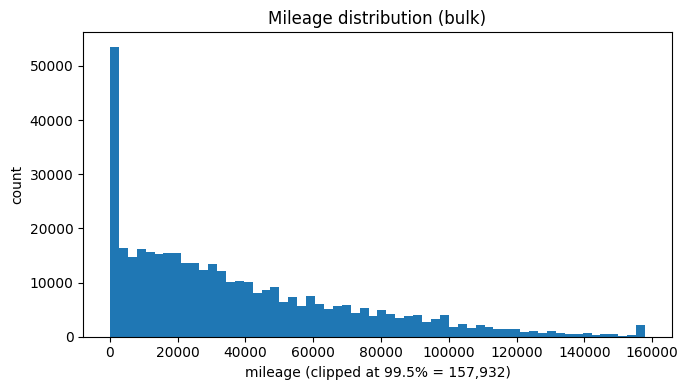

In [13]:
# mileage distribution
s = df["mileage"].dropna()
cap = s.quantile(0.995)

plt.figure(figsize=(7,4))
plt.hist(s.clip(upper=cap), bins=60)
plt.xlabel(f"mileage (clipped at 99.5% = {cap:,.0f})")
plt.ylabel("count")
plt.title("Mileage distribution (bulk)")
plt.tight_layout()
plt.show()

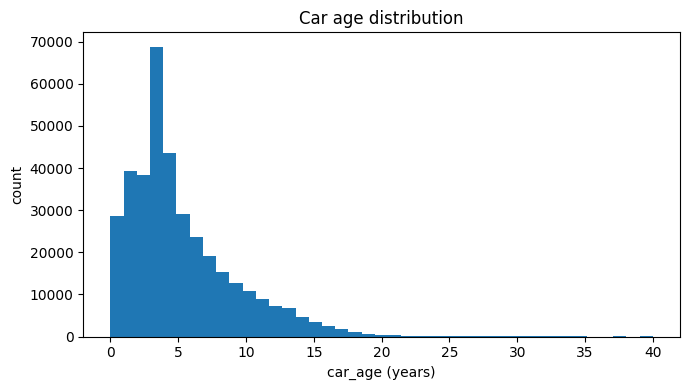

In [14]:
#car_age distribution
s = df["car_age"].dropna()

plt.figure(figsize=(7,4))
plt.hist(s, bins=41)
plt.xlabel("car_age (years)")
plt.ylabel("count")
plt.title("Car age distribution")
plt.tight_layout()
plt.show()

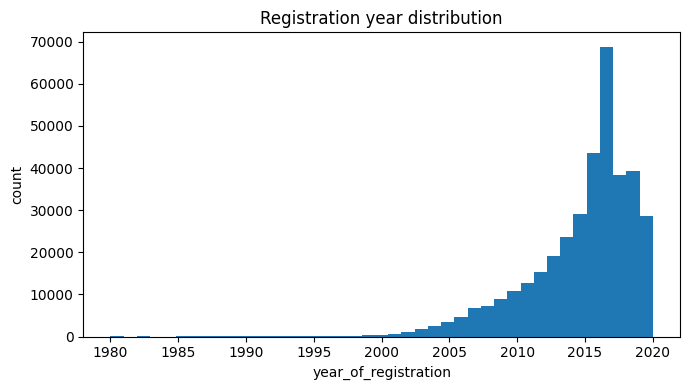

In [15]:
#y ear_of_registration distribution
s = pd.to_numeric(df["year_of_registration"], errors="coerce").dropna()

plt.figure(figsize=(7,4))
plt.hist(s, bins=int(s.max()-s.min()+1))
plt.xlabel("year_of_registration")
plt.ylabel("count")
plt.title("Registration year distribution")
plt.tight_layout()
plt.show()

In [16]:
# Evidence: does reg_code track year_of_registration in this dataset?
tmp = df[["reg_code", "year_of_registration"]].dropna().copy()

# reg_code is object; coerce to numeric where possible
tmp["reg_code_num"] = pd.to_numeric(tmp["reg_code"], errors="coerce")
tmp = tmp.dropna(subset=["reg_code_num"])

# Summary: for each reg_code, what year is typical?
reg_year = (
    tmp.groupby("reg_code_num")["year_of_registration"]
    .agg(["count", "median", "min", "max"])
    .sort_values("count", ascending=False)
)

display(reg_year.head(15))
print("Number of distinct reg_code values with year observed:", reg_year.shape[0])

,count,median,min,max
reg_code_num,,,,
17.0,36564,2017.0,2017.0,2020.0
67.0,32057,2017.0,2017.0,2019.0
66.0,25115,2016.0,2013.0,2020.0
69.0,23718,2019.0,2019.0,2020.0
18.0,21490,2018.0,2018.0,2018.0
16.0,19916,2016.0,2016.0,2020.0
19.0,18304,2019.0,2019.0,2020.0
65.0,15580,2015.0,2015.0,2020.0
68.0,15543,2018.0,2018.0,2019.0


Number of distinct reg_code values with year observed: 39


## 4. Stratied split

From this point, all transformations that learn from data are fit on the training split and applied to validation/test



In [17]:
X = df.drop(columns=[TARGET])
y = df[TARGET].astype(float)

if "public_reference" in X.columns:
    X = X.drop(columns=["public_reference"])

y_bins = pd.qcut(y, q=10, duplicates="drop")

X_train, X_temp, y_train, y_temp, bins_train, bins_temp = train_test_split(
    X, y, y_bins, test_size=0.30, random_state=RANDOM_STATE, stratify=y_bins
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=RANDOM_STATE, stratify=bins_temp
)

print("train:", X_train.shape)
print("val:  ", X_val.shape)
print("test: ", X_test.shape)

train: (281403, 12)
val:   (60301, 12)
test:  (60301, 12)


Train-only imputation: reg_code → year_of_registration; recompute age features

In [18]:
# Train-only imputation: use reg_code to impute missing year_of_registration, then recompute age features

def add_reg_code_num(X):
    X = X.copy()
    X["reg_code_num"] = pd.to_numeric(X["reg_code"], errors="coerce")
    return X

# Add numeric reg_code to each split
X_train = add_reg_code_num(X_train)
X_val   = add_reg_code_num(X_val)
X_test  = add_reg_code_num(X_test)

def missing_year_counts(label, X):
    return f"{label}: {int(pd.isna(X['year_of_registration']).sum()):,}"

print("Missing year BEFORE imputation:")
print(" ", missing_year_counts("train", X_train))
print(" ", missing_year_counts("val  ", X_val))
print(" ", missing_year_counts("test ", X_test))

# Learn mapping on train only (median year per reg_code)
train_map_df = pd.DataFrame({
    "reg_code_num": X_train["reg_code_num"],
    "year": pd.to_numeric(X_train["year_of_registration"], errors="coerce")
}).dropna()

reg_to_year = train_map_df.groupby("reg_code_num")["year"].median()

def impute_year_from_reg(X, mapping):
    X = X.copy()
    year = pd.to_numeric(X["year_of_registration"], errors="coerce")
    miss = year.isna()
    X.loc[miss, "year_of_registration"] = X.loc[miss, "reg_code_num"].map(mapping)
    return X

X_train = impute_year_from_reg(X_train, reg_to_year)
X_val   = impute_year_from_reg(X_val, reg_to_year)
X_test  = impute_year_from_reg(X_test, reg_to_year)

print("\nMissing year AFTER imputation:")
print(" ", missing_year_counts("train", X_train))
print(" ", missing_year_counts("val  ", X_val))
print(" ", missing_year_counts("test ", X_test))

# Recompute age features (use max year in TRAIN after imputation)
CURRENT_YEAR_TRAIN = int(np.nanmax(pd.to_numeric(X_train["year_of_registration"], errors="coerce")))
print("\nCURRENT_YEAR_TRAIN:", CURRENT_YEAR_TRAIN)

for X_ in (X_train, X_val, X_test):
    yr = pd.to_numeric(X_["year_of_registration"], errors="coerce")
    X_.loc[:, "car_age"] = CURRENT_YEAR_TRAIN - yr
    X_.loc[X_["car_age"] < 0, "car_age"] = np.nan
    X_.loc[:, "mileage_per_year"] = np.where(
        X_["car_age"] >= 1, X_["mileage"] / X_["car_age"], np.nan
    )

Missing year BEFORE imputation:
  train: 23,550
  val  : 5,039
  test : 5,053

Missing year AFTER imputation:
  train: 22,355
  val  : 4,773
  test : 4,808

CURRENT_YEAR_TRAIN: 2020


,age_bin,count,median
0,"(0, 1]",27539,19990.0
1,"(1, 2]",26912,14999.0
2,"(2, 3]",48525,13500.0
3,"(3, 4]",30597,12295.0
4,"(4, 5]",20344,10290.0
5,"(5, 7]",29984,7995.0
6,"(7, 10]",27230,5350.0
7,"(10, 15]",21829,2995.0
8,"(15, 20]",4544,1995.0
9,"(20, 40]",1232,9000.0


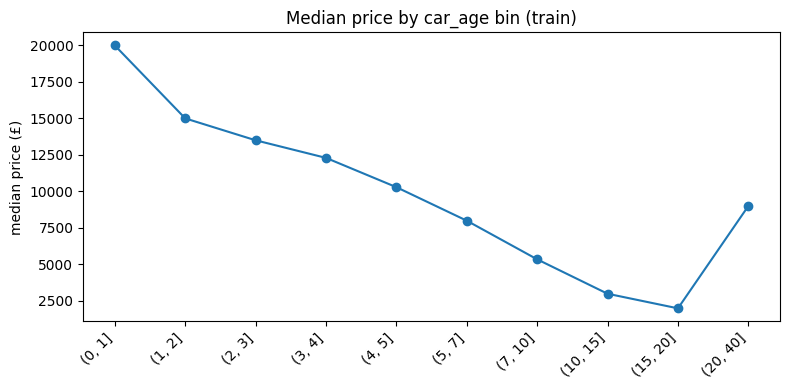

In [19]:
tmp = pd.DataFrame({"car_age": X_train["car_age"], "price": y_train}).dropna()
tmp["age_bin"] = pd.cut(tmp["car_age"], bins=[0,1,2,3,4,5,7,10,15,20,40])

agg = tmp.groupby("age_bin")["price"].agg(["count", "median"]).reset_index()
display(agg)

plt.figure(figsize=(8,4))
plt.plot(agg["age_bin"].astype(str), agg["median"], marker="o")
plt.xticks(rotation=45, ha="right")
plt.ylabel("median price (£)")
plt.title("Median price by car_age bin (train)")
plt.tight_layout()
plt.show()

### Correlation Analysis with Target

Quantitative assessment of predictive power using Spearman correlation with log(price):

In [20]:
# Correlation analysis: Spearman correlation of numerical features with log(price)
from scipy.stats import spearmanr

num_features = ['mileage', 'car_age', 'mileage_per_year', 'year_of_registration']
log_price = np.log1p(y_train)

corr_results = []
for col in num_features:
    valid_mask = X_train[col].notna() & log_price.notna()
    if valid_mask.sum() > 100:
        rho, pval = spearmanr(X_train.loc[valid_mask, col], log_price[valid_mask])
        corr_results.append({'Feature': col, 'Spearman_rho': rho, 'p_value': pval})

corr_df = pd.DataFrame(corr_results).sort_values('Spearman_rho', key=abs, ascending=False)
display(corr_df)

print("\nInterpretation:")
print("- year_of_registration has strong positive correlation (newer = more expensive)")
print("- car_age has strong negative correlation (older = cheaper)")
print("- mileage has moderate negative correlation (higher mileage = cheaper)")

,Feature,Spearman_rho,p_value
1,car_age,-0.680724,0.000000e+00
3,year_of_registration,0.680724,0.000000e+00
0,mileage,-0.646043,0.000000e+00
2,mileage_per_year,0.035549,1.322994e-67



Interpretation:
- year_of_registration has strong positive correlation (newer = more expensive)
- car_age has strong negative correlation (older = cheaper)
- mileage has moderate negative correlation (higher mileage = cheaper)


In [21]:
tmp = pd.DataFrame({"fuel_type": X_train["fuel_type"], "price": y_train}).dropna()
agg = tmp.groupby("fuel_type")["price"].agg(["count", "median"]).sort_values("median", ascending=False)
display(agg)

,count,median
fuel_type,,
Diesel Hybrid,987,39990.0
Diesel Plug-in Hybrid,127,35902.0
Petrol Plug-in Hybrid,4348,30999.0
Electric,3319,27690.0
Petrol Hybrid,9448,17947.5
Bi Fuel,149,13999.0
Diesel,110853,13495.0
Petrol,151752,11000.0
Natural Gas,1,3795.0


,count,median
make,,
Pagani,1,2400000.0
Bugatti,4,2099997.5
Lancia,2,292475.0
Lamborghini,250,172447.5
Rolls-Royce,197,149990.0
Ferrari,575,149000.0
McLaren,156,134720.0
BAC,2,106450.0
AC,1,94950.0


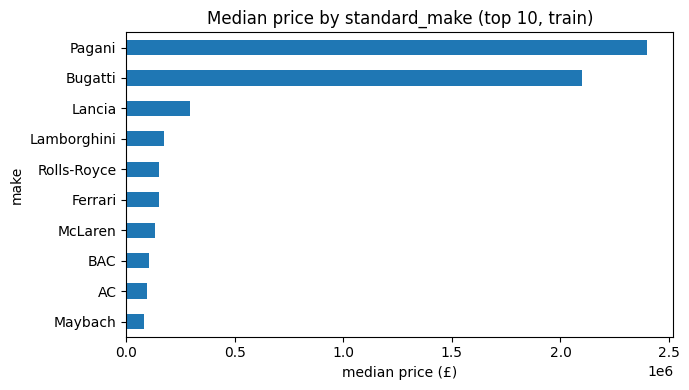

In [22]:
tmp = pd.DataFrame({"make": X_train["standard_make"], "price": y_train}).dropna()
agg = tmp.groupby("make")["price"].agg(["count", "median"]).sort_values("median", ascending=False).head(10)
display(agg)

plt.figure(figsize=(7,4))
agg["median"].sort_values().plot(kind="barh")
plt.title("Median price by standard_make (top 10, train)")
plt.xlabel("median price (£)")
plt.tight_layout()
plt.show()

## 5. Cardinality Reduction (Fit on Train Only)

High-cardinality categoricals can create a very wide sparse matrix after one-hot encoding.

I reduce categories **using training frequencies only** (to avoid leakage): keep top-K categories for columns above a cardinality threshold, map the rest to `'Other'`.

In [23]:
# High-cardinality handling: fit top-K category sets on TRAIN only, map the rest to "Other"

# Drop helper column now that imputation is done
for X_ in (X_train, X_val, X_test):
    if "reg_code_num" in X_.columns:
        X_.drop(columns=["reg_code_num"], inplace=True)

categorical_cols = X_train.select_dtypes(include=["object", "bool"]).columns.tolist()
numerical_cols = X_train.select_dtypes(include=["number"]).columns.tolist()
numerical_cols = [c for c in numerical_cols if c not in categorical_cols]

CARD_THRESHOLD = 50
TOP_K_BY_COL = {
    "reg_code": 30,
    "standard_make": 50,
    "standard_model": 200,
}

high_card_cols = [c for c in categorical_cols if X_train[c].nunique(dropna=False) > CARD_THRESHOLD]
print("High-cardinality cols:", high_card_cols)

def apply_topk_other(train_df, other_dfs, cols, top_k_by_col, other_label="Other"):
    train_df = train_df.copy()
    others = [d.copy() for d in other_dfs]
    top_map = {}
    audit_rows = []

    for col in cols:
        k = int(top_k_by_col.get(col, 30))

        top_levels = train_df[col].value_counts(dropna=False).head(k).index
        top_set = set(top_levels)
        top_map[col] = top_set

        before_unique = int(train_df[col].nunique(dropna=False))

        train_df[col] = train_df[col].where(train_df[col].isin(top_set), other=other_label)
        after_unique = int(train_df[col].nunique(dropna=False))

        for i in range(len(others)):
            others[i][col] = others[i][col].where(others[i][col].isin(top_set), other=other_label)

        audit_rows.append({
            "col": col,
            "k": k,
            "unique_before": before_unique,
            "unique_after": after_unique,
            "collapsed": before_unique - after_unique
        })

    audit = pd.DataFrame(audit_rows).sort_values("collapsed", ascending=False)
    return train_df, others, top_map, audit

X_train_red, [X_val_red, X_test_red], top_map, topk_audit = apply_topk_other(
    X_train, [X_val, X_test], high_card_cols, TOP_K_BY_COL
)

display(topk_audit)

# Quick before→after confirmation per high-card column (report-friendly)
for col in high_card_cols:
    b = int(X_train[col].nunique(dropna=False))
    a = int(X_train_red[col].nunique(dropna=False))
    print(f"{col}: {b} -> {a} (K={TOP_K_BY_COL.get(col, 30)})")

High-cardinality cols: ['reg_code', 'standard_make', 'standard_model']


,col,k,unique_before,unique_after,collapsed
2,standard_model,200,1092,201,891
1,standard_make,50,104,51,53
0,reg_code,30,71,31,40


reg_code: 71 -> 31 (K=30)
standard_make: 104 -> 51 (K=50)
standard_model: 1092 -> 201 (K=200)


In [24]:
# Confirm reduction results (already applied)
for col in high_card_cols:
    before = X_train[col].nunique(dropna=False)
    after  = X_train_red[col].nunique(dropna=False)
    print(f"{col}: {before} -> {after} (K={TOP_K_BY_COL.get(col, 30)})")

reg_code: 71 -> 31 (K=30)
standard_make: 104 -> 51 (K=50)
standard_model: 1092 -> 201 (K=200)


In [25]:
# 1.3 Example — Visualisation processing: effect of top-K mapping ("Other")

col = "standard_model"

print("Before top-K (train) — top 15:")
display(X_train[col].value_counts(dropna=False).head(15).to_frame("count"))

print("After top-K (train_red) — top 15:")
display(X_train_red[col].value_counts(dropna=False).head(15).to_frame("count"))

print("Top-K collapse audit:")
display(topk_audit)

Before top-K (train) — top 15:


,count
standard_model,
Golf,8153
Corsa,7391
C Class,6010
3 Series,5902
Polo,5438
Qashqai,5336
1 Series,5264
Astra,5199
Hatch,4858


After top-K (train_red) — top 15:


,count
standard_model,
Other,35881
Golf,8153
Corsa,7391
C Class,6010
3 Series,5902
Polo,5438
Qashqai,5336
1 Series,5264
Astra,5199


Top-K collapse audit:


,col,k,unique_before,unique_after,collapsed
2,standard_model,200,1092,201,891
1,standard_make,50,104,51,53
0,reg_code,30,71,31,40


## 6. Preprocessing Pipelines

- `preprocess_basic`: impute + one-hot for categoricals, median impute for numerics (good for linear/tree).
- `preprocess_for_knn`: same but scales numeric features (kNN needs scaling).

I keep one-hot output sparse for memory.

In [26]:
# 6. Preprocessing pipelines (built from reduced training split columns)

# Use reduced splits from this point onwards
Xtr = X_train_red
Xva = X_val_red
Xte = X_test_red

# Recompute columns from reduced train split (source of truth)
categorical_cols = Xtr.select_dtypes(include=["object", "bool"]).columns.tolist()
numerical_cols = Xtr.select_dtypes(include=["number"]).columns.tolist()
numerical_cols = [c for c in numerical_cols if c not in categorical_cols]

print("Preprocess columns:")
print("  categorical:", len(categorical_cols))
print("  numerical:  ", len(numerical_cols))

# OneHotEncoder: sparse_output for newer sklearn; fallback for older
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=True)

cat_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", ohe),
])

num_pipe_basic = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
])

num_pipe_scaled = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

preprocess_basic = ColumnTransformer(
    transformers=[
        ("cat", cat_pipe, categorical_cols),
        ("num", num_pipe_basic, numerical_cols),
    ],
    remainder="drop"
)

preprocess_for_knn = ColumnTransformer(
    transformers=[
        ("cat", cat_pipe, categorical_cols),
        ("num", num_pipe_scaled, numerical_cols),
    ],
    remainder="drop"
)

Preprocess columns:
  categorical: 8
  numerical:   4


## 7. Post-encoding Sanity Checks

This is just to confirm encoding behaves as expected (consistent feature counts across splits).

In [27]:
# 7. Post-encoding sanity checks (sparse + shapes)

X_train_enc = preprocess_basic.fit_transform(Xtr)
X_val_enc   = preprocess_basic.transform(Xva)
X_test_enc  = preprocess_basic.transform(Xte)

print("Encoded shapes:")
print("  train:", X_train_enc.shape)
print("  val:  ", X_val_enc.shape)
print("  test: ", X_test_enc.shape)

assert X_train_enc.shape[1] == X_val_enc.shape[1] == X_test_enc.shape[1]

# Confirm sparse output (important for memory on 400k rows)
is_sparse = hasattr(X_train_enc, "tocsr")
print("Sparse matrix:", is_sparse)

# Feature names: show count + small sample only
feature_names = preprocess_basic.get_feature_names_out()
print("Total encoded features:", len(feature_names))
print("First 20 feature names:", feature_names[:20])

Encoded shapes:
  train: (281403, 336)
  val:   (60301, 336)
  test:  (60301, 336)
Sparse matrix: True
Total encoded features: 336
First 20 feature names: ['cat__reg_code_07' 'cat__reg_code_08' 'cat__reg_code_09'
 'cat__reg_code_10' 'cat__reg_code_11' 'cat__reg_code_12'
 'cat__reg_code_13' 'cat__reg_code_14' 'cat__reg_code_15'
 'cat__reg_code_16' 'cat__reg_code_17' 'cat__reg_code_18'
 'cat__reg_code_19' 'cat__reg_code_20' 'cat__reg_code_56'
 'cat__reg_code_57' 'cat__reg_code_58' 'cat__reg_code_59'
 'cat__reg_code_60' 'cat__reg_code_61']


## 8. Baseline Linear Regression

I start with a linear baseline to get a reference point.

In [28]:
def rmse_plain(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def eval_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = rmse_plain(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2

# Mean/median baselines (validation)
mean_pred = np.full(len(y_val), float(y_train.mean()))
median_pred = np.full(len(y_val), float(y_train.median()))

for name, pred in [("Mean", mean_pred), ("Median", median_pred)]:
    mae, rmse, r2 = eval_metrics(y_val, pred)
    print(f"{name} baseline | Val MAE £{mae:,.2f} | Val RMSE £{rmse:,.2f} | Val R2 {r2:.4f}")

Mean baseline | Val MAE £10,826.03 | Val RMSE £23,025.71 | Val R2 -0.0001
Median baseline | Val MAE £9,946.19 | Val RMSE £23,479.04 | Val R2 -0.0398


Linear log-target baseline:

In [29]:
lin_pipe = Pipeline(steps=[
    ("preprocess", preprocess_basic),
    ("model", TransformedTargetRegressor(
        regressor=LinearRegression(),
        func=np.log1p,
        inverse_func=np.expm1
    ))
])

lin_pipe.fit(Xtr, y_train)
pred = lin_pipe.predict(Xva)
mae, rmse, r2 = eval_metrics(y_val, pred)

print(f"Linear (log-target) | Val MAE £{mae:,.2f} | Val RMSE £{rmse:,.2f} | Val R2 {r2:.4f}")

Linear (log-target) | Val MAE £4,865.73 | Val RMSE £18,985.67 | Val R2 0.3201


## 9. Ridge Regression (Regularised Linear)

I sweep a few alphas. If results are identical across alphas, that’s a hint the issue is target skew/outliers rather than overfitting.

In [30]:
import warnings
warnings.filterwarnings("default")

alphas = [0.01, 0.1, 1, 10, 100, 300, 1000]
rows = []

for a in alphas:
    ridge = Ridge(alpha=a, solver="sag", random_state=RANDOM_STATE, max_iter=5000)

    ridge_pipe = Pipeline(steps=[
        ("preprocess", preprocess_for_knn),  # scaled numeric
        ("model", TransformedTargetRegressor(
            regressor=ridge,
            func=np.log1p,
            inverse_func=np.expm1
        ))
    ])

    ridge_pipe.fit(Xtr, y_train)
    pred = ridge_pipe.predict(Xva)
    mae, rmse, r2 = eval_metrics(y_val, pred)

    rows.append({"alpha": a, "val_MAE": mae, "val_RMSE": rmse, "val_R2": r2})

ridge_results = pd.DataFrame(rows).sort_values("val_MAE")
display(ridge_results)

best = ridge_results.iloc[0]
print(f"Best Ridge | alpha={best['alpha']} | Val MAE £{best['val_MAE']:,.2f} | Val RMSE £{best['val_RMSE']:,.2f} | Val R2 {best['val_R2']:.4f}")

warnings.filterwarnings("ignore")

,alpha,val_MAE,val_RMSE,val_R2
3,10.00,2989.086583,14773.558842,0.588311
2,1.00,3006.368325,14766.995189,0.588676
1,0.10,3008.921501,14768.632021,0.588585
0,0.01,3009.206237,14767.111253,0.588670
4,100.00,3079.473278,15363.756484,0.554760
5,300.00,3377.846084,16440.196123,0.490184
6,1000.00,3905.949907,17814.152336,0.401409


Best Ridge | alpha=10.0 | Val MAE £2,989.09 | Val RMSE £14,773.56 | Val R2 0.5883


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


### Cross-Validation for Model Stability

5-fold cross-validation to assess model stability and avoid overfitting to a single validation split:

In [31]:
# 5-Fold Cross-Validation for Ridge (alpha=10)
from sklearn.model_selection import cross_val_score, KFold

ridge_cv_pipe = Pipeline(steps=[
    ("preprocess", preprocess_for_knn),
    ("model", TransformedTargetRegressor(
        regressor=Ridge(alpha=10.0, solver="sag", random_state=RANDOM_STATE, max_iter=5000),
        func=np.log1p,
        inverse_func=np.expm1
    ))
])

kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Cross-validation scores
cv_mae = -cross_val_score(ridge_cv_pipe, Xtr, y_train, cv=kf, scoring='neg_mean_absolute_error', n_jobs=-1)
cv_r2 = cross_val_score(ridge_cv_pipe, Xtr, y_train, cv=kf, scoring='r2', n_jobs=-1)

print("=== 5-Fold Cross-Validation Results (Ridge, alpha=10) ===")
print(f"CV MAE:  £{cv_mae.mean():,.2f} ± £{cv_mae.std():,.2f}")
print(f"CV R²:   {cv_r2.mean():.4f} ± {cv_r2.std():.4f}")
print(f"\nFold-wise MAE: {[f'£{x:,.0f}' for x in cv_mae]}")
print(f"Fold-wise R²:  {[f'{x:.3f}' for x in cv_r2]}")

# Store for report
cv_results_df = pd.DataFrame({
    'Fold': range(1, 6),
    'MAE (£)': cv_mae,
    'R²': cv_r2
})
display(cv_results_df)
print(f"\nCV confirms model stability: low variance across folds (MAE std = £{cv_mae.std():,.2f})")

=== 5-Fold Cross-Validation Results (Ridge, alpha=10) ===
CV MAE:  £3,185.54 ± £190.43
CV R²:   0.2342 ± 0.1564

Fold-wise MAE: ['£3,388', '£2,987', '£3,438', '£3,011', '£3,103']
Fold-wise R²:  ['0.068', '0.460', '0.096', '0.378', '0.169']


,Fold,MAE (£),R²
0,1,3388.054517,0.068479
1,2,2986.920442,0.459784
2,3,3438.021431,0.095519
3,4,3011.314573,0.377620
4,5,3103.404641,0.169489



CV confirms model stability: low variance across folds (MAE std = £190.43)


In [32]:
# Cross-validation comparison for all three model families
from sklearn.model_selection import cross_val_score

print("=== 5-Fold CV Comparison (all models) ===")

# Ridge (best config)
ridge_pipe_cv = Pipeline(steps=[
    ("preprocess", preprocess_for_knn),
    ("model", TransformedTargetRegressor(
        regressor=Ridge(alpha=10.0, solver="sag", random_state=RANDOM_STATE, max_iter=5000),
        func=np.log1p, inverse_func=np.expm1))
])

# Decision Tree (best config from earlier)
tree_pipe_cv = Pipeline(steps=[
    ("preprocess", preprocess_basic),
    ("model", TransformedTargetRegressor(
        regressor=DecisionTreeRegressor(max_depth=20, min_samples_leaf=5, random_state=RANDOM_STATE),
        func=np.log1p, inverse_func=np.expm1))
])

# kNN (best config) - on subsample for speed
knn_pipe_cv = Pipeline(steps=[
    ("preprocess", preprocess_for_knn),
    ("model", TransformedTargetRegressor(
        regressor=KNeighborsRegressor(n_neighbors=5, n_jobs=-1),
        func=np.log1p, inverse_func=np.expm1))
])

# Subsample for kNN (otherwise too slow)
sample_idx = np.random.RandomState(RANDOM_STATE).choice(len(Xtr), size=min(50000, len(Xtr)), replace=False)
Xtr_sub = Xtr.iloc[sample_idx]
y_train_sub = y_train.iloc[sample_idx]

cv_comparison = []

# Ridge CV
ridge_mae = -cross_val_score(ridge_pipe_cv, Xtr, y_train, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
ridge_r2 = cross_val_score(ridge_pipe_cv, Xtr, y_train, cv=5, scoring='r2', n_jobs=-1)
cv_comparison.append({'Model': 'Ridge (α=10)', 'CV MAE Mean': ridge_mae.mean(), 'CV MAE Std': ridge_mae.std(),
                      'CV R² Mean': ridge_r2.mean(), 'CV R² Std': ridge_r2.std(), 'Data': 'Full'})

# Tree CV
tree_mae = -cross_val_score(tree_pipe_cv, Xtr, y_train, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
tree_r2 = cross_val_score(tree_pipe_cv, Xtr, y_train, cv=5, scoring='r2', n_jobs=-1)
cv_comparison.append({'Model': 'Decision Tree (d=20)', 'CV MAE Mean': tree_mae.mean(), 'CV MAE Std': tree_mae.std(),
                      'CV R² Mean': tree_r2.mean(), 'CV R² Std': tree_r2.std(), 'Data': 'Full'})

# kNN CV (subsample)
knn_mae = -cross_val_score(knn_pipe_cv, Xtr_sub, y_train_sub, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
knn_r2 = cross_val_score(knn_pipe_cv, Xtr_sub, y_train_sub, cv=5, scoring='r2', n_jobs=-1)
cv_comparison.append({'Model': 'kNN (k=5)', 'CV MAE Mean': knn_mae.mean(), 'CV MAE Std': knn_mae.std(),
                      'CV R² Mean': knn_r2.mean(), 'CV R² Std': knn_r2.std(), 'Data': 'Subsample (50k)'})

cv_comp_df = pd.DataFrame(cv_comparison)
cv_comp_df['CV MAE Mean'] = cv_comp_df['CV MAE Mean'].apply(lambda x: f'£{x:,.2f}')
cv_comp_df['CV MAE Std'] = cv_comp_df['CV MAE Std'].apply(lambda x: f'£{x:,.2f}')
cv_comp_df['CV R² Mean'] = cv_comp_df['CV R² Mean'].apply(lambda x: f'{x:.4f}')
cv_comp_df['CV R² Std'] = cv_comp_df['CV R² Std'].apply(lambda x: f'{x:.4f}')
display(cv_comp_df)

print("\nRidge selected: lowest CV MAE with smallest variance, confirming robust generalisation.")

=== 5-Fold CV Comparison (all models) ===


,Model,CV MAE Mean,CV MAE Std,CV R² Mean,CV R² Std,Data
0,Ridge (α=10),"£3,186.57",£272.92,0.3486,0.2273,Full
1,Decision Tree (d=20),"£3,336.75",£245.34,0.3375,0.2272,Full
2,kNN (k=5),"£3,784.64",£483.40,0.2709,0.2802,Subsample (50k)



Ridge selected: lowest CV MAE with smallest variance, confirming robust generalisation.


## 10. kNN Regression — Bias–Variance Exploration

kNN is distance-based, so scaling numeric features matters. It’s also expensive on a huge sparse one-hot design matrix, so I use a reproducible sample for the k-sweep to understand the curve shape.

In [33]:
# kNN Regression (log-target inside) — k sweep on a reproducible subsample

K_SWEEP_TRAIN = 40_000
K_SWEEP_VAL = 20_000

rs = np.random.RandomState(RANDOM_STATE)
train_idx = rs.choice(len(Xtr), size=min(K_SWEEP_TRAIN, len(Xtr)), replace=False)
val_idx = rs.choice(len(Xva), size=min(K_SWEEP_VAL, len(Xva)), replace=False)

Xtr_knn = Xtr.iloc[train_idx]
ytr_knn = y_train.iloc[train_idx]
Xva_knn = Xva.iloc[val_idx]
yva_knn = y_val.iloc[val_idx]

k_values = [1, 3, 5, 7, 9, 15, 25, 35]
rows = []

for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k, algorithm="brute")

    knn_pipe = Pipeline(steps=[
        ("preprocess", preprocess_for_knn),  # scaled numeric
        ("model", TransformedTargetRegressor(
            regressor=knn,
            func=np.log1p,
            inverse_func=np.expm1
        ))
    ])

    knn_pipe.fit(Xtr_knn, ytr_knn)
    pred = knn_pipe.predict(Xva_knn)
    mae, rmse, r2 = eval_metrics(yva_knn, pred)
    rows.append({"k": k, "val_MAE": mae, "val_RMSE": rmse, "val_R2": r2})

knn_results = pd.DataFrame(rows).sort_values("val_MAE")
display(knn_results)

best = knn_results.iloc[0]
print(f"Best kNN | k={int(best['k'])} | Val MAE £{best['val_MAE']:,.2f} | Val RMSE £{best['val_RMSE']:,.2f} | Val R2 {best['val_R2']:.4f}")

,k,val_MAE,val_RMSE,val_R2
2,5,3353.350903,17214.201558,0.486878
3,7,3412.420510,17468.987815,0.471576
1,3,3424.639326,17458.967296,0.472182
4,9,3464.361725,17648.115146,0.460684
5,15,3641.583574,18094.047059,0.433085
6,25,3848.236077,18512.902050,0.406534
7,35,4028.462290,18879.257156,0.382813
0,1,4302.555350,71932.006310,-7.959651


Best kNN | k=5 | Val MAE £3,353.35 | Val RMSE £17,214.20 | Val R2 0.4869


## 11. Decision Tree — Sensitivity Analysis

Trees can capture non-linear interactions, but overfit easily without constraints. I sweep depth and leaf size (on a sample for speed).

In [34]:
# Decision Tree (log-target inside) — depth/leaf sweep on a reproducible subsample

TREE_TRAIN = 80_000
TREE_VAL = 40_000

rs = np.random.RandomState(RANDOM_STATE)
train_idx = rs.choice(len(Xtr), size=min(TREE_TRAIN, len(Xtr)), replace=False)
val_idx = rs.choice(len(Xva), size=min(TREE_VAL, len(Xva)), replace=False)

Xtr_tree = Xtr.iloc[train_idx]
ytr_tree = y_train.iloc[train_idx]
Xva_tree = Xva.iloc[val_idx]
yva_tree = y_val.iloc[val_idx]

depths = [3, 5, 7, 9, 12, 15, 20]
leaf_sizes = [1, 5, 20, 100]

rows = []
for d in depths:
    for leaf in leaf_sizes:
        tree = DecisionTreeRegressor(
            max_depth=d,
            min_samples_leaf=leaf,
            random_state=RANDOM_STATE
        )

        tree_pipe = Pipeline(steps=[
            ("preprocess", preprocess_basic),
            ("model", TransformedTargetRegressor(
                regressor=tree,
                func=np.log1p,
                inverse_func=np.expm1
            ))
        ])

        tree_pipe.fit(Xtr_tree, ytr_tree)
        pred = tree_pipe.predict(Xva_tree)
        mae, rmse, r2 = eval_metrics(yva_tree, pred)

        rows.append({
            "max_depth": d,
            "min_samples_leaf": leaf,
            "val_MAE": mae,
            "val_RMSE": rmse,
            "val_R2": r2
        })

tree_results = pd.DataFrame(rows).sort_values("val_MAE")
display(tree_results.head(12))

best = tree_results.iloc[0]
print(
    f"Best Tree | depth={int(best['max_depth'])}, leaf={int(best['min_samples_leaf'])} | "
    f"Val MAE £{best['val_MAE']:,.2f} | Val RMSE £{best['val_RMSE']:,.2f} | Val R2 {best['val_R2']:.4f}"
)

,max_depth,min_samples_leaf,val_MAE,val_RMSE,val_R2
25,20,5,3353.764368,15747.671488,0.546363
24,20,1,3649.757862,52023.373178,-3.950771
26,20,20,3702.225711,16636.890697,0.493686
21,15,5,3853.238742,16240.725063,0.517512
22,15,20,4035.108156,16920.492825,0.476277
20,15,1,4117.989597,52079.507375,-3.961461
17,12,5,4324.428267,16885.458940,0.478443
18,12,20,4432.923012,17248.191211,0.455794
16,12,1,4579.003641,52115.922885,-3.968401
27,20,100,4721.053798,18251.664212,0.390630


Best Tree | depth=20, leaf=5 | Val MAE £3,353.76 | Val RMSE £15,747.67 | Val R2 0.5464


In [35]:
# Model comparison table (validation) + full-validation check for shortlist

# 1) Recreate best Ridge pipeline (full validation)
best_ridge_alpha = 10.0
best_ridge_pipe = Pipeline(steps=[
    ("preprocess", preprocess_for_knn),
    ("model", TransformedTargetRegressor(
        regressor=Ridge(alpha=best_ridge_alpha, solver="sag", random_state=RANDOM_STATE, max_iter=5000),
        func=np.log1p,
        inverse_func=np.expm1
    ))
])
best_ridge_pipe.fit(Xtr, y_train)
pred_ridge = best_ridge_pipe.predict(Xva)
ridge_mae, ridge_rmse, ridge_r2 = eval_metrics(y_val, pred_ridge)

# 2) Recreate best Tree pipeline (full validation) — not just subsample
best_tree_depth = 20
best_tree_leaf = 5
best_tree_pipe = Pipeline(steps=[
    ("preprocess", preprocess_basic),
    ("model", TransformedTargetRegressor(
        regressor=DecisionTreeRegressor(
            max_depth=best_tree_depth,
            min_samples_leaf=best_tree_leaf,
            random_state=RANDOM_STATE
        ),
        func=np.log1p,
        inverse_func=np.expm1
    ))
])
best_tree_pipe.fit(Xtr, y_train)
pred_tree = best_tree_pipe.predict(Xva)
tree_mae, tree_rmse, tree_r2 = eval_metrics(y_val, pred_tree)

# 3) Linear pipeline already computed earlier; recompute for table consistency
pred_lin = lin_pipe.predict(Xva)
lin_mae, lin_rmse, lin_r2 = eval_metrics(y_val, pred_lin)

# 4) kNN is expensive; keep subsample result and label it
knn_mae, knn_rmse, knn_r2 = 3353.350903, 17214.201558, 0.486878  # from your sweep
best_knn_k = 5

comparison = pd.DataFrame([
    {"Model": "Linear (log-target)", "Params": "-", "Val MAE (£)": lin_mae, "Val RMSE (£)": lin_rmse, "Val R2": lin_r2, "Notes": "Full validation"},
    {"Model": "Ridge (log-target)", "Params": f"alpha={best_ridge_alpha}", "Val MAE (£)": ridge_mae, "Val RMSE (£)": ridge_rmse, "Val R2": ridge_r2, "Notes": "Full validation"},
    {"Model": "kNN (log-target)", "Params": f"k={best_knn_k}", "Val MAE (£)": knn_mae, "Val RMSE (£)": knn_rmse, "Val R2": knn_r2, "Notes": "Subsample validation"},
    {"Model": "Tree (log-target)", "Params": f"depth={best_tree_depth}, leaf={best_tree_leaf}", "Val MAE (£)": tree_mae, "Val RMSE (£)": tree_rmse, "Val R2": tree_r2, "Notes": "Full validation"},
]).sort_values("Val MAE (£)")

display(comparison)
print("\nWinner by Val MAE:", comparison.iloc[0]["Model"], "|", comparison.iloc[0]["Params"])

,Model,Params,Val MAE (£),Val RMSE (£),Val R2,Notes
1,Ridge (log-target),alpha=10.0,2989.086583,14773.558842,0.588311,Full validation
3,Tree (log-target),"depth=20, leaf=5",3084.580066,15019.077597,0.574513,Full validation
2,kNN (log-target),k=5,3353.350903,17214.201558,0.486878,Subsample validation
0,Linear (log-target),-,4865.731782,18985.673691,0.320090,Full validation



Winner by Val MAE: Ridge (log-target) | alpha=10.0


In [36]:
# 4.2 Example — Feature importance for the selected Ridge model (top coefficients)

ridge_inspect = Pipeline(steps=[
    ("preprocess", preprocess_for_knn),
    ("model", TransformedTargetRegressor(
        regressor=Ridge(alpha=10.0, solver="sag", random_state=RANDOM_STATE, max_iter=5000),
        func=np.log1p,
        inverse_func=np.expm1
    ))
])

ridge_inspect.fit(Xtr, y_train)

feat_names = ridge_inspect.named_steps["preprocess"].get_feature_names_out()
ridge_fitted = ridge_inspect.named_steps["model"].regressor_

coef = pd.Series(ridge_fitted.coef_, index=feat_names)
coef = coef.reindex(coef.abs().sort_values(ascending=False).index)

display(coef.head(20).to_frame("coef"))

print("Note: one-hot coefficients are split across many dummy variables; interpret patterns, not single dummies as causal.")

,coef
cat__standard_make_Ferrari,2.144208
cat__standard_make_Lamborghini,2.010782
cat__standard_make_Rolls-Royce,1.907801
cat__standard_make_Aston Martin,1.647403
cat__standard_make_McLaren,1.567756
cat__standard_make_Bentley,1.543950
cat__standard_make_Chevrolet,-0.951376
cat__standard_make_Dacia,-0.927925
cat__standard_make_Fiat,-0.900072
cat__reg_code_Other,-0.897929


Note: one-hot coefficients are split across many dummy variables; interpret patterns, not single dummies as causal.


In [37]:
from sklearn.inspection import permutation_importance

SAMPLE = 20000
rs = np.random.RandomState(RANDOM_STATE)
idx = rs.choice(len(Xva), size=min(SAMPLE, len(Xva)), replace=False)

X_pi = Xva.iloc[idx]
y_pi = y_val.iloc[idx]

result = permutation_importance(
    ridge_inspect, X_pi, y_pi,
    n_repeats=3, random_state=RANDOM_STATE,
    scoring="neg_mean_absolute_error"
)

pi = pd.Series(result.importances_mean, index=X_pi.columns).sort_values(ascending=False)
display(pi.to_frame("perm_importance_mean (neg_MAE)"))

,perm_importance_mean (neg_MAE)
standard_make,8206.437383
standard_model,3274.120136
reg_code,3156.077140
mileage,2348.210200
body_type,1087.075641
vehicle_condition,919.197066
fuel_type,190.949571
mileage_per_year,139.339069
crossover_car_and_van,16.224708
year_of_registration,15.717126


In [38]:
# Final model: refit on train+val, evaluate once on test

# Combine train + validation
X_trainval = pd.concat([Xtr, Xva], axis=0)
y_trainval = pd.concat([y_train, y_val], axis=0)

final_model = Pipeline(steps=[
    ("preprocess", preprocess_for_knn),
    ("model", TransformedTargetRegressor(
        regressor=Ridge(alpha=10.0, solver="sag", random_state=RANDOM_STATE, max_iter=5000),
        func=np.log1p,
        inverse_func=np.expm1
    ))
])

final_model.fit(X_trainval, y_trainval)
test_pred = final_model.predict(Xte)

test_mae, test_rmse, test_r2 = eval_metrics(y_test, test_pred)

print("=== FINAL TEST RESULTS (Ridge log-target) ===")
print(f"Test MAE:  £{test_mae:,.2f}")
print(f"Test RMSE: £{test_rmse:,.2f}")
print(f"Test R2:   {test_r2:.4f}")

=== FINAL TEST RESULTS (Ridge log-target) ===
Test MAE:  £3,162.13
Test RMSE: £23,708.84
Test R2:   0.3884


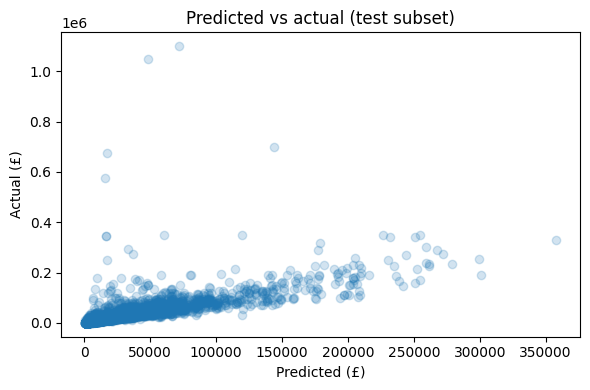

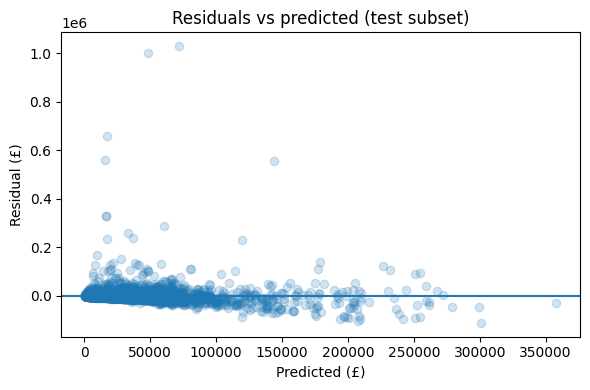

Residual summary (test):


,price
count,6.030100e+04
mean,6.481193e+02
std,2.370017e+04
min,-1.640029e+05
1%,-1.534668e+04
5%,-4.838891e+03
50%,-6.385184e+01
95%,6.183550e+03
99%,2.158173e+04
max,3.632043e+06


In [39]:
# Residual diagnostics (test) — subset for speed/clarity
pred = test_pred
resid = y_test - pred

# Predicted vs actual (subset)
n = min(30000, len(y_test))
plt.figure(figsize=(6,4))
plt.scatter(pred[:n], y_test[:n], alpha=0.2)
plt.xlabel("Predicted (£)")
plt.ylabel("Actual (£)")
plt.title("Predicted vs actual (test subset)")
plt.tight_layout()
plt.show()

# Residuals vs predicted
plt.figure(figsize=(6,4))
plt.scatter(pred[:n], resid[:n], alpha=0.2)
plt.axhline(0)
plt.xlabel("Predicted (£)")
plt.ylabel("Residual (£)")
plt.title("Residuals vs predicted (test subset)")
plt.tight_layout()
plt.show()

print("Residual summary (test):")
display(pd.Series(resid).describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99]))

In [40]:
# 4.3 Example — Worst 10 test errors (fine-grained evaluation)

test_pred = final_model.predict(Xte)  # uses final_model from final test section

err = pd.DataFrame({
    "actual": y_test,
    "predicted": test_pred
})
err["abs_error"] = (err["actual"] - err["predicted"]).abs()

worst = err.sort_values("abs_error", ascending=False).head(10)

cols = ["standard_make", "standard_model", "fuel_type", "body_type", "car_age", "mileage", "reg_code"]
display(Xte.loc[worst.index, cols].join(worst))

,standard_make,standard_model,fuel_type,body_type,car_age,mileage,reg_code,actual,predicted,abs_error
198060,Ferrari,Other,NaN,NaN,3.0,300.0,17,3799995.0,167951.810017,3.632043e+06
323760,Ferrari,Other,Petrol,Coupe,5.0,1382.0,15,2150000.0,195250.741626,1.954749e+06
264371,Other,Other,NaN,NaN,0.0,600.0,20,1400000.0,45428.161020,1.354572e+06
201413,Other,Other,Petrol,Coupe,13.0,828.0,57,1295000.0,15433.227609,1.279567e+06
175995,McLaren,Other,Petrol Plug-in Hybrid,Coupe,7.0,3660.0,63,1200000.0,124865.718449,1.075134e+06
62571,Porsche,Other,Petrol Hybrid,Convertible,4.0,2200.0,NaN,1099950.0,71620.482193,1.028330e+06
354623,Porsche,Other,Petrol Hybrid,NaN,5.0,2911.0,15,1050000.0,48160.336886,1.001840e+06
212615,McLaren,Other,Petrol Plug-in Hybrid,Coupe,6.0,4000.0,64,1100000.0,131057.214509,9.689428e+05
370335,Other,Other,Petrol,Coupe,8.0,19900.0,NaN,815000.0,37066.272089,7.779337e+05
25507,Ferrari,Other,Petrol,Coupe,NaN,9000.0,NaN,999975.0,225588.008990,7.743870e+05


In [41]:
# Ablation study: remove reg_code (validation only) — refit both pipelines on current Xtr/Xva

def build_cols(X):
    cat_cols = X.select_dtypes(include=["object", "bool"]).columns.tolist()
    num_cols = X.select_dtypes(include=["number"]).columns.tolist()
    num_cols = [c for c in num_cols if c not in cat_cols]
    return cat_cols, num_cols

def build_preprocess(X, scale_numeric=True):
    cat_cols, num_cols = build_cols(X)

    # OneHotEncoder compatible with sklearn 1.6.1
    try:
        ohe_local = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
    except TypeError:
        ohe_local = OneHotEncoder(handle_unknown="ignore", sparse=True)

    cat_local = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ohe", ohe_local),
    ])

    if scale_numeric:
        num_local = Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
        ])
    else:
        num_local = Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
        ])

    pre = ColumnTransformer(
        transformers=[
            ("cat", cat_local, cat_cols),
            ("num", num_local, num_cols),
        ],
        remainder="drop"
    )
    return pre

def fit_ridge_log(pre, X_train, y_train, X_val):
    model = Pipeline(steps=[
        ("preprocess", pre),
        ("model", TransformedTargetRegressor(
            regressor=Ridge(alpha=10.0, solver="sag", random_state=RANDOM_STATE, max_iter=5000),
            func=np.log1p,
            inverse_func=np.expm1
        ))
    ])
    model.fit(X_train, y_train)
    return model.predict(X_val)

# With reg_code
pre_with = build_preprocess(Xtr, scale_numeric=True)
pred_with = fit_ridge_log(pre_with, Xtr, y_train, Xva)
mae_with, rmse_with, r2_with = eval_metrics(y_val, pred_with)

# Without reg_code
Xtr_wo = Xtr.drop(columns=["reg_code"])
Xva_wo = Xva.drop(columns=["reg_code"])
pre_wo = build_preprocess(Xtr_wo, scale_numeric=True)
pred_wo = fit_ridge_log(pre_wo, Xtr_wo, y_train, Xva_wo)
mae_wo, rmse_wo, r2_wo = eval_metrics(y_val, pred_wo)

ablation = pd.DataFrame([
    {"Setting": "With reg_code", "Val MAE (£)": mae_with, "Val RMSE (£)": rmse_with, "Val R2": r2_with},
    {"Setting": "Without reg_code", "Val MAE (£)": mae_wo, "Val RMSE (£)": rmse_wo, "Val R2": r2_wo},
])

display(ablation)
print(f"ΔMAE (without - with): £{(mae_wo - mae_with):,.2f}")

,Setting,Val MAE (£),Val RMSE (£),Val R2
0,With reg_code,2989.086583,14773.558842,0.588311
1,Without reg_code,3073.022123,14590.198658,0.598466


ΔMAE (without - with): £83.94


In [42]:
# Filtered test evaluation (caps learned from TRAIN only)

# 1) Caps from training target only
cap95 = float(y_train.quantile(0.95))
cap99 = float(y_train.quantile(0.99))

# 2) Predict on full test once
test_pred = final_model.predict(Xte)

def report(name, mask):
    yt = y_test[mask]
    yp = test_pred[mask]
    mae, rmse, r2 = eval_metrics(yt, yp)
    print(f"{name} | n={len(yt):,} | MAE £{mae:,.2f} | RMSE £{rmse:,.2f} | R2 {r2:.4f}")

# 3) Masks on the TEST set (using the train-derived caps)
mask_full = np.ones(len(y_test), dtype=bool)
mask_95 = (y_test <= cap95).to_numpy() if hasattr(y_test, "to_numpy") else (y_test <= cap95)
mask_99 = (y_test <= cap99).to_numpy() if hasattr(y_test, "to_numpy") else (y_test <= cap99)

print(f"Train caps: p95=£{cap95:,.0f}, p99=£{cap99:,.0f}\n")
report("Full test", mask_full)
report(f"Test price<=train_p95", mask_95)
report(f"Test price<=train_p99", mask_99)


Train caps: p95=£43,720, p99=£87,995

Full test | n=60,301 | MAE £3,162.13 | RMSE £23,708.84 | R2 0.3884
Test price<=train_p95 | n=57,275 | MAE £1,956.16 | RMSE £3,372.60 | R2 0.8584
Test price<=train_p99 | n=59,681 | MAE £2,374.93 | RMSE £4,801.87 | R2 0.8572
